### 데이터 불러오기

In [43]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
SEED = 1030

In [44]:
data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(32),
        transforms.Normalize((0.5,), (1.0,))
    ]
)

train_data = datasets.MNIST(root="./", train=True, download=True, transform=data_transform)
test_data = datasets.MNIST(root="./", train=False, download=True, transform=data_transform)


In [45]:

# print(f"train\tX: {train_data.data.shape}, y: {train_data.targets.shape}")
# print(f"test\tX: {test_data.data.shape}, y: {test_data.targets.shape}")

# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# train_loader

# Train/Validation 분할 (80:20 비율)
train_size = int(0.8 * len(train_data))   # 48,000개
val_size = len(train_data) - train_size   # 12,000개
train_dataset, val_dataset = random_split(
    train_data, [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)  # 시드값 고정
)

print(f"train\tX: {len(train_dataset)}")
print(f"val\tX: {len(val_dataset)}")

train	X: 48000
val	X: 12000


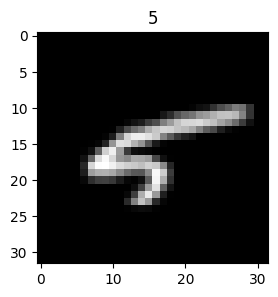

In [46]:
import matplotlib.pyplot as plt

# 데이터 1개 그림 그리기
idx = 1
fig, ax = plt.subplots(figsize=(3, 3))
# ax.imshow(train_data.data[1], cmap="gray")

# ax.imshow(train_X[idx], cmap="gray")
# ax.set_title(train_y[idx].item())
image, label = train_dataset[idx] 
ax.imshow(image.squeeze(), cmap="gray")  # 이미지 표시
ax.set_title(label) 

plt.show()

In [47]:

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

# 전체 데이터를 로드하여 Shape 확인
train_X, train_y = next(iter(train_loader))
val_X, val_y = next(iter(val_loader))
# test_X, test_y = next(iter(test_loader))

# 채널 차원 제거
train_X = train_X.squeeze()  # (48000, 32, 32)
val_X = val_X.squeeze()      # (12000, 32, 32)
# test_X = test_X.squeeze()    # (10000, 28, 28)

# 데이터셋 정보 출력
print(f"train\tX: {train_X.shape}, y: {train_y.shape}")
print(f"val\tX: {val_X.shape}, y: {val_y.shape}")
print(f"test\tX: {test_data.data.shape}, y: {test_data.targets.shape}")


train	X: torch.Size([32, 32, 32]), y: torch.Size([32])
val	X: torch.Size([32, 32, 32]), y: torch.Size([32])
test	X: torch.Size([10000, 28, 28]), y: torch.Size([10000])


In [48]:
for data, target in train_loader:
    print(data.shape)
    print(target)
    print(data.reshape(-1, 32*32))
    break
    

torch.Size([32, 1, 32, 32])
tensor([4, 6, 5, 7, 1, 2, 6, 4, 4, 6, 0, 0, 6, 0, 5, 2, 1, 5, 1, 2, 7, 7, 8, 8,
        9, 0, 2, 4, 4, 1, 8, 7])
tensor([[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        ...,
        [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]])


### 모델 설정

In [49]:
import torch
from torch import nn

class MnistNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(32*32, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.softmax(x)
        return x
    

model = MnistNet()
model

MnistNet(
  (layer1): Linear(in_features=1024, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [50]:
from torchsummary import summary
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
summary(model, input_size=(1, 32*32))

print((32*32 + 1) * 64)
print((64 + 1) * 32)
print((32 + 1) * 10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]          65,600
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 32]           2,080
              ReLU-4                [-1, 1, 32]               0
            Linear-5                [-1, 1, 10]             330
           Softmax-6                [-1, 1, 10]               0
Total params: 68,010
Trainable params: 68,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.26
Estimated Total Size (MB): 0.26
----------------------------------------------------------------
65600
2080
330


### 학습

In [51]:
from torch import optim
import copy  # 모델 가중치 복사를 위한 모듈

In [52]:
# model.load_state_dict(torch.load("model_30.pth"))  # 기존 모델 불러오기

# 하이퍼 파라미터
epochs = 100
patience = 10  # Early Stopping 허용 에폭 수
best_val_loss = float('inf')  # 초기 검증 손실
counter = 0   # Early Stopping 카운터

criterion = nn.CrossEntropyLoss()  # 손실함수
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # 최적화 함수

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
}


for epoch in range(epochs):
    ### train
    model.train()
    loss_train = 0.0
    correct, total = 0, 0
    
    for data, target in train_loader:
        # gpu로 보내기
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 32 * 32)  # Flatten
        
        # 학습과정
        optimizer.zero_grad()
        yhat = model(data)
        loss = criterion(yhat, target)
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item()
        preds = torch.argmax(yhat, dim=1)  # 정확도 계산
        correct += (preds == target).sum().item()
        total += target.size(0)
    
    train_loss = loss_train / len(train_loader)
    history['train_loss'].append(train_loss)
    
    train_accuracy = 100 * correct / total
    history['train_acc'].append(train_accuracy)
    
    ### validation
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():  # 역전파 X
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            data = data.reshape(-1, 32 * 32)

            yhat = model(data)
            loss = criterion(yhat, target)

            val_loss += loss.item()
            preds = torch.argmax(yhat, dim=1)
            val_correct += (preds == target).sum().item()
            val_total += target.size(0)

    val_loss = val_loss / len(val_loader)
    history['val_loss'].append(val_loss)
    
    val_accuracy = 100 * val_correct / val_total
    history['val_acc'].append(val_accuracy)
    
    # 결과 출력
    print(
        f"Epoch: {epoch}\t"
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%"
    )
    
    # Early Stopping 및 모델 저장
    if val_loss < best_val_loss:  #  성능 개선 확인 (검증 손실 기준)
        best_val_loss = val_loss
        counter = 0  # Early Stopping 카운터 초기화
    else:
        counter += 1
        print(f"개선 없음 - Early Stopping 카운터: {counter}/{patience}")

        if counter >= patience:  # Early Stopping 조건 만족 시 학습 종료
            print("Early Stopping 조건 충족 - 학습 중단")
            break
    
    # 모델 저장
    if epoch % 10 == 0:
        best_model_wts = copy.deepcopy(model.state_dict())  # 가중치 복사
        model_name = f"model_{epoch}"
        torch.save(model.state_dict(), f'{model_name}.pth')  # 모델 가중치만 저장
        print(f"모델 저장 완료: {model_name}")


# # 최적 모델 로드
# model.load_state_dict(best_model_wts)



Epoch: 0	Train Loss: 1.6635, Train Acc: 82.06% | Val Loss: 1.5719, Val Acc: 89.72%
모델 저장 완료: model_0
Epoch: 1	Train Loss: 1.5631, Train Acc: 90.34% | Val Loss: 1.5492, Val Acc: 91.79%
Epoch: 2	Train Loss: 1.5503, Train Acc: 91.37% | Val Loss: 1.5483, Val Acc: 91.62%
Epoch: 3	Train Loss: 1.5430, Train Acc: 92.10% | Val Loss: 1.5368, Val Acc: 92.67%
Epoch: 4	Train Loss: 1.5354, Train Acc: 92.78% | Val Loss: 1.5370, Val Acc: 92.70%
개선 없음 - Early Stopping 카운터: 1/10
Epoch: 5	Train Loss: 1.5292, Train Acc: 93.38% | Val Loss: 1.5261, Val Acc: 93.63%
Epoch: 6	Train Loss: 1.5255, Train Acc: 93.70% | Val Loss: 1.5357, Val Acc: 92.77%
개선 없음 - Early Stopping 카운터: 1/10
Epoch: 7	Train Loss: 1.5213, Train Acc: 94.12% | Val Loss: 1.5241, Val Acc: 93.79%
Epoch: 8	Train Loss: 1.5180, Train Acc: 94.42% | Val Loss: 1.5200, Val Acc: 94.14%
Epoch: 9	Train Loss: 1.5155, Train Acc: 94.66% | Val Loss: 1.5176, Val Acc: 94.39%
Epoch: 10	Train Loss: 1.5133, Train Acc: 94.91% | Val Loss: 1.5228, Val Acc: 93.94%
개선

<Figure size 600x400 with 0 Axes>

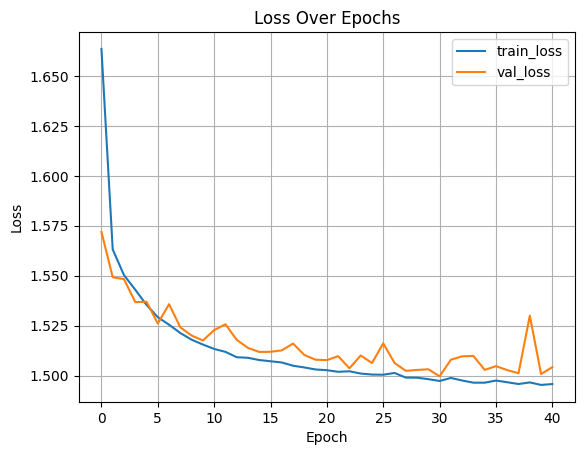

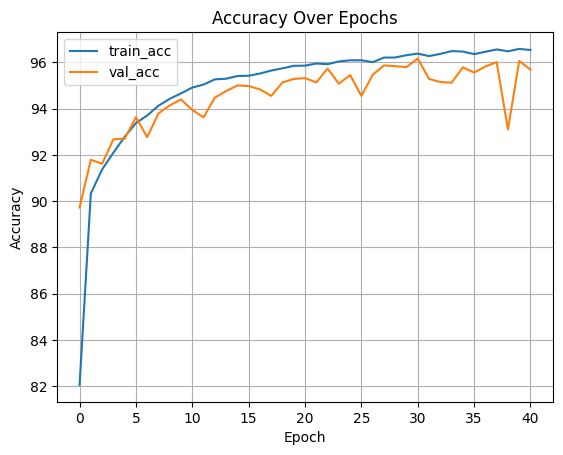

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# 학습 곡선 시각화
plt.figure(figsize=(6, 4))

# Train Loss와 Validation Loss 각각 그리기
loss_data = pd.DataFrame(history)

# loss_data.plot()
loss_data[["train_loss", "val_loss"]].plot()

# 그래프 제목 및 라벨 설정

plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()  # 그리드 추가
plt.show()

loss_data[["train_acc", "val_acc"]].plot()

# 그래프 제목 및 라벨 설정
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()  # 그리드 추가
plt.show()
